In [1]:
import numpy as np
import pandas as pd
import time
import os
import re

In [2]:
import math

def make_batches_from_dataset(df, batch_size):
    num_batch = math.ceil(df.shape[0] / batch_size)
    df_batches = []
    start_index = 0
    for i in range(num_batch):
        df_batches.append(df[start_index : start_index + batch_size])
        start_index = start_index + batch_size
    return df_batches

In [3]:
def get_last_index(idx_file_name):
    last_idx = 0
    # read from file
    try:
        last_idx = pd.read_csv(idx_file_name)
        last_idx = last_idx.values[0][0]
    except FileNotFoundError as fnfe:
        last_idx = 0
    return last_idx

In [4]:
def save_data_till_last_iteration(df, file_name, idx_file_name):
    #df_strategyqa_eval.to_csv("/kaggle/working/strategyqa-train-filtered-with-alpaca-13B-ans.csv", index=False)
    df.to_csv(file_name, index=False)
    global last_idx
    #pd.Series(data=[last_idx]).to_csv("/kaggle/working/strategyqa-last-idx.csv", index=False)
    pd.Series(data=[last_idx]).to_csv(idx_file_name, index=False)

In [5]:
def is_file_exist(filename):
    file_exist = False
    for _, _, filenames in os.walk('/kaggle/working'):
        if filename in filenames:
            file_exist = True
            break
    return file_exist

In [24]:
def iter_cot_bootstrapping_module(bootstrapping_limit):
    correct_answer = strategyqa[1]["answer"]
    print(f"Index: {strategyqa[0]}")
    str_correct_answer = ""
    if correct_answer == True:
        str_correct_answer = "yes"
    if correct_answer == False:
        str_correct_answer = "no"
    model_answer = ""
    final_answer = ""
    cot_answer_attempt = 0
    while final_answer != str_correct_answer:
        if cot_answer_attempt == bootstrapping_limit:
            break
        if cot_answer_attempt == 0:
            PROMPT = f"""Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. \
Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
        else:
            if final_answer == "unknown":
                PROMPT = f"""{model_answer}

According to the above template, the final answer is missing in your previous output. So, give me the final answer of the following question correctly. Please add final answer after the reasoning paragraph.

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
            else:
                PROMPT = f"""{model_answer}

Your above reasoning and final answer are not correct. You please again think deeply and step by step. After that, you please do not repeat previous reasoning, change your previous reasoning and final answer. \
Then again give me the new reasoning and final answer of the following question correctly.

Moreover, according to the above template, either reasoning or final answer is missing in your previous output. Please add final answer after the reasoning paragraph.

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
        
        inputs = tokenizer(
            PROMPT,
            return_tensors="pt",
        )
        input_ids = inputs["input_ids"].to('cuda:0')
        generation_config = GenerationConfig(
            temperature=0.5,
            top_p=0.95,
            repetition_penalty=1.15,
        )
        print("Generating...")
        output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1024,#128
        )
        model_answer = tokenizer.decode(output.sequences[0])
        print(model_answer)
        print("---------------------------------------------------")
        final_answer = model_answer.lower()
        if final_answer.rfind("final answer: ") == -1:
            if final_answer[-3:] == "yes":
                final_answer = "yes"
            elif final_answer[-2:] == "no":
                final_answer = "no"
            else:
                final_answer = final_answer.rsplit(" ", 1)[1]
                if re.search(r"yes", final_answer) != None:
                    final_answer = "yes"
                elif re.search(r"no", final_answer) != None:
                    final_answer = "no"
                else:
                    final_answer = "unknown"
        else:
            final_answer = final_answer[final_answer.rfind("final answer: ") + 14:]
            if final_answer.startswith("yes"):
                final_answer = "yes"
            elif final_answer.startswith("no"):
                final_answer = "no"
            else:
                if final_answer[-3:] == "yes":
                    final_answer = "yes"
                elif final_answer[-2:] == "no":
                    final_answer = "no"
                else:
                    final_answer = final_answer.rsplit(" ", 1)[1]
                    if re.search(r"yes", final_answer) != None:
                        final_answer = "yes"
                    elif re.search(r"no", final_answer) != None:
                        final_answer = "no"
                    else:
                        final_answer = "unknown"
        print(final_answer)
        print("------------------------------------")
        cot_answer_attempt = cot_answer_attempt + 1
    if cot_answer_attempt < bootstrapping_limit:
        iter_cot_answer = model_answer[model_answer.rfind("A:"):]
        if iter_cot_answer.lower().rfind("final answer: ") == -1:
            iter_cot_answer = iter_cot_answer + f" Final Answer: {final_answer}"
        print("------Modified-----------")
        print(iter_cot_answer)
        print("----------------------")
        print(final_answer)
        print("---------------------------")
        df_strategyqa_train.loc[strategyqa[0], "iter-cot-answer"] = iter_cot_answer
        df_strategyqa_train.loc[strategyqa[0], "final-answer"] = final_answer
        df_strategyqa_train.loc[strategyqa[0], "iter-cot-answer-tokens-length"] = len(tokenizer.encode(iter_cot_answer))
        df_strategyqa_train.loc[strategyqa[0], "num-iteration-to-correct"] = cot_answer_attempt - 1
    print(f"Iteration: {cot_answer_attempt - 1}")
    print("------------------------------------------------------------")

In [7]:
def iter_cot_inference_module(trial_no, num_batch, few_shots_exemplars, idx, question, answer):
    for i in range(len(few_shots_exemplars) + 1):
        if i == 0:
            PROMPT = f"""{iter_cot_few_shots_prompt}

Q: {question}
A:"""
        else:
            fsp = iter_cot_few_shots_prompt + "\n\n" + "\n\n".join(few_shots_exemplars[:i])
            PROMPT = f"""{fsp}

Q: {question}
A:"""

        model_answer = ""

        inputs = tokenizer(
            PROMPT,
            return_tensors="pt",
        )
        input_ids = inputs["input_ids"].to('cuda:0')
        generation_config = GenerationConfig(
            temperature=0,
            top_p=0.95,
            repetition_penalty=1.15,
        )
        print("Generating...")
        output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1024, #128
        )
        model_answer = tokenizer.decode(output.sequences[0])
        print(f"trail no : {trial_no}, batch number : {num_batch}, index : {idx}")
        print("------------------------------------------")
        print(model_answer)
        print("---------------------------------------------------")
        final_answer = model_answer.lower()
        if final_answer.rfind("final answer: ") == -1:
            if final_answer[-3:] == "yes":
                final_answer = "yes"
            elif final_answer[-2:] == "no":
                final_answer = "no"
            else:
                final_answer = final_answer.rsplit(" ", 1)[1]
                if re.search(r"yes", final_answer) != None:
                    final_answer = "yes"
                elif re.search(r"no", final_answer) != None:
                    final_answer = "no"
                else:
                    final_answer = "unknown"
        else:
            final_answer = final_answer[final_answer.rfind("final answer: ") + 14:]
            if final_answer.startswith("yes"):
                final_answer = "yes"
            elif final_answer.startswith("no"):
                final_answer = "no"
            else:
                if final_answer[-3:] == "yes":
                    final_answer = "yes"
                elif final_answer[-2:] == "no":
                    final_answer = "no"
                else:
                    final_answer = final_answer.rsplit(" ", 1)[1]
                    if re.search(r"yes", final_answer) != None:
                        final_answer = "yes"
                    elif re.search(r"no", final_answer) != None:
                        final_answer = "no"
                    else:
                        final_answer = "unknown"
        print(final_answer)
        print("------------------------------------")
        df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}"""] = model_answer[model_answer.rfind("A:"):]
        if final_answer == "yes" and answer == True:
            df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}-correct"""] = True
        if final_answer == "no" and answer == False:
            df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}-correct"""] = True

In [8]:
!pip install -U accelerate peft transformers bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [9]:
from peft import PeftModel, PeftConfig
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

#peft_model_id = "chansung/alpaca-lora-13b"
#peft_model_id = "chansung/gpt4-alpaca-lora-13b"
peft_model_id = "chansung/alpaca-lora-30b"
#peft_model_id = "chansung/gpt4-alpaca-lora-30b"
#peft_model_id = "chansung/alpaca-lora-65b"

#peft_model_id = "meta-llama/Llama-2-7b-chat-hf"
#peft_model_id = "meta-llama/Llama-2-13b-chat-hf"
#peft_model_id = "meta-llama/Llama-2-70b-chat-hf"

#llm_name = "alpaca-lora-13b"
#llm_name = "gpt4-alpaca-lora-13b"
llm_name = "alpaca-lora-30b"
#llm_name = "gpt4-alpaca-lora-30b"
#llm_name = "alpaca-lora-65b"

#llm_name = "Llama-2-7b-chat-hf"
#llm_name = "Llama-2-13b-chat-hf"
#llm_name = "Llama-2-70b-chat-hf"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [10]:
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path

'decapoda-research/llama-30b-hf'

In [11]:
model = LlamaForCausalLM.from_pretrained(config.base_model_name_or_path, 
                                        low_cpu_mem_usage=True, 
                                        device_map="auto",
                                        load_in_4bit=True)

Loading checkpoint shards:   0%|          | 0/61 [00:00<?, ?it/s]

In [12]:
model = PeftModel.from_pretrained(model, peft_model_id)

In [13]:
tokenizer = LlamaTokenizer.from_pretrained(config.base_model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [14]:
df_strategyqa_train = pd.read_json("/kaggle/input/strategyqa-dataset-for-thesis/strategyqa_train.json")
df_strategyqa_train

qid                                  term  \
0     b8677742616fef051f00                          Genghis Khan   
1     4668264df84fb7c25b39                            The Police   
2     41450dbd623437269f8f                     Depression (mood)   
3     7419826e4373eb1e83ff                             Grey seal   
4     1b29d402c3e17cb3b435                        Pound sterling   
...                    ...                                   ...   
2285  a0c8f44c4b3ad35df66e                               Catfish   
2286  2079d6c0fea33860fbc3                              Achilles   
2287  60fe2d35b5abf0f0652a                          Alec Baldwin   
2288  8c599ce83178d5c0f480  Prime Minister of the United Kingdom   
2289  76f183dc037e7b30e2a2                                    Pi   

                                            description  \
0     founder and first Great Khan of the Mongol Empire   
1                                     English rock band   
2                         state of low mood and fatigue   
3                                       species of seal   
4     Official currency of the United Kingdom and ot...   
...                                                 ...   
2285                                    order of fishes   
2286                            Greek mythological hero   
2287     American actor, writer, producer, and comedian   
2288                              Head of UK Government   
2289  Ratio of the circumference of a circle to its ...   

                                               question  answer  \
0     Are more people today related to Genghis Khan ...    True   
1     Could the members of The Police perform lawful...   False   
2     Would a Monoamine Oxidase candy bar cheer up a...   False   
3         Would a dog respond to bell before Grey seal?    True   
4                         Is a pound sterling valuable?   False   
...                                                 ...     ...   
2285  Is a cory catfish likely to eat another living...   False   
2286  Does Thiago Moises May 13 2020 submission move...    True   
2287  Does Alec Baldwin have more children than Clin...   False   
2288  Does highest US Court have enough seats for ev...   False   
2289  Was Pi an acceptable number of children in 198...   False   

                                                  facts  \
0     [Julius Caesar had three children., Genghis Kh...   
1     [The members of The Police were musicians, not...   
2     [Depression is caused by low levels of seroton...   
3     [Grey seals have no ear flaps and their ears c...   
4     [A pound sterling is fiat money., Fiat money i...   
...                                                 ...   
2285  [The cory catfish is a fish that is described ...   
2286  [Thiago Moises is a mixed martial arts fighter...   
2287  [Alec Baldwin has 5 children as of 2020., Acto...   
2288  [The highest court in the US is the Supreme Co...   
2289  [Pi, the ratio of a circle's circumference to ...   

                                          decomposition  \
0     [How many kids did Julius Caesar have?, How ma...   
1     [Who can perform lawful arrests?, Are members ...   
2     [Depression is caused by low levels of what ch...   
3     [How sensitive is a grey seal's hearing on lan...   
4     [What is the value of the Pound Sterling based...   
...                                                 ...   
2285   [What do cory catfish eat?, Is fish part of #1?]   
2286  [ What was Thiago Moises' winning move the mat...   
2287  [How many children does Alec Baldwin presently...   
2288  [What is the highest United States court?, How...   
2289  [How many children were Chinese parents limite...   

                                               evidence  
0     [[[['Caesarion-2', 'Julia (daughter of Caesar)...  
1     [[[['Arrest-2']], [["Citizen's arrest-2", 'The...  
2     [[[['Monoamine oxidase-8']], [['Monoamine oxid...  
3     [[[['Pinniped-24']], [['Hearing rang

In [17]:
df_strategyqa_train.dtypes

qid              object
term             object
description      object
question         object
answer             bool
facts            object
decomposition    object
evidence         object
dtype: object

In [18]:
!pip install -U ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 7.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ydata-profiling
    Found existing installation: ydata-profiling 4.3.1
    Uninstalling ydata-profiling-4.3.1:
      Successfully uninstalled ydata-profiling-4.3.1


In [19]:
from ydata_profiling import ProfileReport

data_profile_config_path = "/kaggle/input/data-profile/bht_thesis_config_1.yaml"
strategyqa_data_profile_path = "/kaggle/working/df_strategyqa_train_report_v1.html"
profile = ProfileReport(df_strategyqa_train, title="StrategyQA Train Data Profiling Report v1", config_file=data_profile_config_path)
profile.to_file(strategyqa_data_profile_path)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
file_name = "strategyqa-train-with-alpaca-30B-ans.csv"

In [16]:
file_exist = is_file_exist(file_name)
file_exist

True

In [17]:
if file_exist == True:
    df_strategyqa_train = pd.read_csv(f"/kaggle/working/{file_name}")
else:
    default_ans = (['na' for i in range(df_strategyqa_train.shape[0])], [-1 for i in range(df_strategyqa_train.shape[0])])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "iter-cot-answer", default_ans[0])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "final-answer", default_ans[0])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "iter-cot-answer-tokens-length", default_ans[1])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "num-iteration-to-correct", default_ans[1])
df_strategyqa_train

qid                                  term  \
0     b8677742616fef051f00                          Genghis Khan   
1     4668264df84fb7c25b39                            The Police   
2     41450dbd623437269f8f                     Depression (mood)   
3     7419826e4373eb1e83ff                             Grey seal   
4     1b29d402c3e17cb3b435                        Pound sterling   
...                    ...                                   ...   
2285  a0c8f44c4b3ad35df66e                               Catfish   
2286  2079d6c0fea33860fbc3                              Achilles   
2287  60fe2d35b5abf0f0652a                          Alec Baldwin   
2288  8c599ce83178d5c0f480  Prime Minister of the United Kingdom   
2289  76f183dc037e7b30e2a2                                    Pi   

                                            description  \
0     founder and first Great Khan of the Mongol Empire   
1                                     English rock band   
2                         state of low mood and fatigue   
3                                       species of seal   
4     Official currency of the United Kingdom and ot...   
...                                                 ...   
2285                                    order of fishes   
2286                            Greek mythological hero   
2287     American actor, writer, producer, and comedian   
2288                              Head of UK Government   
2289  Ratio of the circumference of a circle to its ...   

                                               question  answer  \
0     Are more people today related to Genghis Khan ...    True   
1     Could the members of The Police perform lawful...   False   
2     Would a Monoamine Oxidase candy bar cheer up a...   False   
3         Would a dog respond to bell before Grey seal?    True   
4                         Is a pound sterling valuable?   False   
...                                                 ...     ...   
2285  Is a cory catfish likely to eat another living...   False   
2286  Does Thiago Moises May 13 2020 submission move...    True   
2287  Does Alec Baldwin have more children than Clin...   False   
2288  Does highest US Court have enough seats for ev...   False   
2289  Was Pi an acceptable number of children in 198...   False   

                                                  facts  \
0     ['Julius Caesar had three children.', 'Genghis...   
1     ['The members of The Police were musicians, no...   
2     ['Depression is caused by low levels of seroto...   
3     ['Grey seals have no ear flaps and their ears ...   
4     ['A pound sterling is fiat money.', 'Fiat mone...   
...                                                 ...   
2285  ['The cory catfish is a fish that is described...   
2286  ['Thiago Moises is a mixed martial arts fighte...   
2287  ['Alec Baldwin has 5 children as of 2020.', 'A...   
2288  ['The highest court in the US is the Supreme C...   
2289  ["Pi, the ratio of a circle's circumference to...   

                                          decomposition  \
0     ['How many kids did Julius Caesar have?', 'How...   
1     ['Who can perform lawful arrests?', 'Are membe...   
2     ['Depression is caused by low levels of what c...   
3     ["How sensitive is a grey seal's hearing on la...   
4     ['What is the value of the Pound Sterling base...   
...                                                 ...   
2285  ['What do cory catfish eat?', 'Is fish part of...   
2286  [" What was Thiago Moises' winning move the ma...   
2287  ['How many children does Alec Baldwin presentl...   
2288  ['What is the highest United States court?', '...   
2289  ['How many children were Chinese parents limit...   

                                               evidence  \
0     [[[['Caesarion-2', 'Julia (daughter of Caesar)...   
1     [[[['Arrest-2']], [["Citizen's arrest-2", 'The...   
2     [[[['Monoamine oxidase-8']], [['Monoamine oxid...   
3     [[[['Pinniped-24']], [['Hearing 

In [18]:
df_strategyqa_train.dtypes

qid                              object
term                             object
description                      object
question                         object
answer                             bool
facts                            object
decomposition                    object
evidence                         object
iter-cot-answer                  object
final-answer                     object
iter-cot-answer-tokens-length     int64
num-iteration-to-correct          int64
dtype: object

In [18]:
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [19]:
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
last_idx

10

In [20]:
batch_size = 50
df_strategyqa_train_batches = make_batches_from_dataset(df_strategyqa_train[last_idx:], batch_size)

In [42]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()

In [21]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [22]:
bootstrapping_limit = 5

In [25]:
batch_count = 1
got_exception = False
for df_strategyqa_train_batch in df_strategyqa_train_batches:
    print(f"Batch: {batch_count}")
    print("-----------------------------")
    for strategyqa in df_strategyqa_train_batch.iterrows():
        try:
            iter_cot_bootstrapping_module(bootstrapping_limit)
        except Exception as exp:
            # print message
            print(exp)
            # save data till previous iteration
            if last_idx != 0:
                save_data_till_last_iteration(df_strategyqa_train, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
            got_exception = True
            break
        last_idx = last_idx + 1
    if got_exception == True:
        break
    save_data_till_last_iteration(df_strategyqa_train, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
    batch_count = batch_count + 1
    time.sleep(60)

Batch: 1
-----------------------------
Index: 10
Generating...
<unk>Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Casio, Japanese electronics company, Can you buy Casio products at Petco?
A: Reasoning: 
Petco sells pet supplies and accessories, so it's unlikely they would sell electronic devices like those made by Casio. Therefore, the answer is most likely "no".
------------

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


CUDA out of memory. Tried to allocate 28.00 MiB (GPU 1; 14.76 GiB total capacity; 13.34 GiB already allocated; 25.75 MiB free; 13.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [22]:
save_data_till_last_iteration(df_strategyqa_train, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")

In [ ]:
# K-iter Demonstrations Pools

In [ ]:
file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
# temprary because of batches and code completion
index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
## temprary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [6]:
df_strategyqa_train = pd.read_csv(f"/kaggle/working/{file_name}")

# temprary because of batches and code completion
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")

df_strategyqa_train_group_by = df_strategyqa_train[:last_idx][["final-answer", "iter-cot-answer-tokens-length", "num-iteration-to-correct"]].groupby(by=["num-iteration-to-correct"])
final_answer_count = df_strategyqa_train_group_by["final-answer"].count()
df_strategyqa_train_performance = pd.DataFrame({
    "num-iteration-to-correct": final_answer_count.index.values,
    "final-answer": final_answer_count.to_list(),
    "answer-tokens-max-length": df_strategyqa_train_group_by["iter-cot-answer-tokens-length"].max().to_list(),
    "answer-tokens-average-length": df_strategyqa_train_group_by["iter-cot-answer-tokens-length"].mean().to_list()
})
df_strategyqa_train_performance

num-iteration-to-correct  final-answer  answer-tokens-max-length  \
0                         0            24                       169   
1                         1            24                       237   
2                         2             1                       126   
3                         3             1                        53   

   answer-tokens-average-length  
0                        81.375  
1                        84.125  
2                       126.000  
3                        53.000

In [ ]:
# final-answer = corrected examples from iteration 1
# accuracy = (correct examples / total examples) * 100

In [ ]:
# temprary because of batches and code completion
index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [6]:
# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
#num_record = df_strategyqa_train.shape[0]
num_record = last_idx

default_ans = ([0 for i in range(df_strategyqa_train_performance.shape[0])], [0.0 for i in range(df_strategyqa_train_performance.shape[0])])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "correct-answer", default_ans[0])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "ratio-correct-incorrect", default_ans[1])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "accuracy", default_ans[1])
for strategyqa_train_performance in df_strategyqa_train_performance.iterrows():
    corrected_answer = strategyqa_train_performance[1]["final-answer"]
    # batch size will be total number of rows in train set
    if strategyqa_train_performance[1]["num-iteration-to-correct"] == 0:
        correct_answer = strategyqa_train_performance[1]["final-answer"]
    else:
        corrected_answer = strategyqa_train_performance[1]["final-answer"]
        correct_answer = correct_answer + corrected_answer
    incorrect_answer = num_record - correct_answer
    df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "correct-answer"] = correct_answer
    if incorrect_answer != 0.0:
        df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "ratio-correct-incorrect"] = float(correct_answer) / float(incorrect_answer)
    df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "accuracy"] = (float(correct_answer) / float(num_record)) * 100.00
df_strategyqa_train_performance

num-iteration-to-correct  final-answer  answer-tokens-max-length  \
0                         0            24                       169   
1                         1            24                       237   
2                         2             1                       126   
3                         3             1                        53   

   answer-tokens-average-length  correct-answer  ratio-correct-incorrect  \
0                        81.375              24                 0.923077   
1                        84.125              48                24.000000   
2                       126.000              49                49.000000   
3                        53.000              50                 0.000000   

   accuracy  
0      48.0  
1      96.0  
2      98.0  
3     100.0

In [22]:
df_strategyqa_train_performance.dtypes

num-iteration-to-correct          int64
final-answer                      int64
answer-tokens-max-length          int64
answer-tokens-average-length    float64
correct-answer                    int64
ratio-correct-incorrect         float64
accuracy                        float64
dtype: object

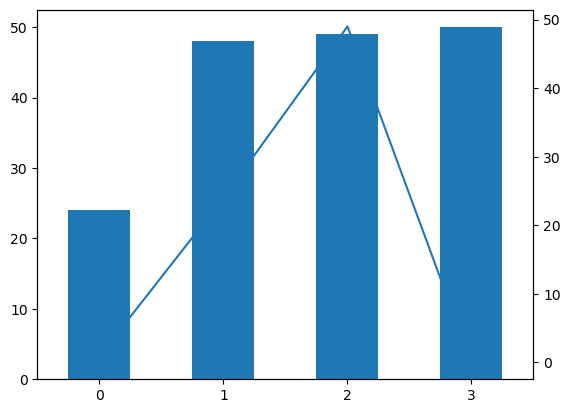

In [23]:
import matplotlib.pyplot as plt

width = .5 # width of a bar

df_strategyqa_train_performance['correct-answer'].plot(kind='bar', width = width)
df_strategyqa_train_performance['ratio-correct-incorrect'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(df_strategyqa_train_performance['num-iteration-to-correct'])-width])
ax.set_xticklabels(df_strategyqa_train_performance['num-iteration-to-correct'])

plt.show()

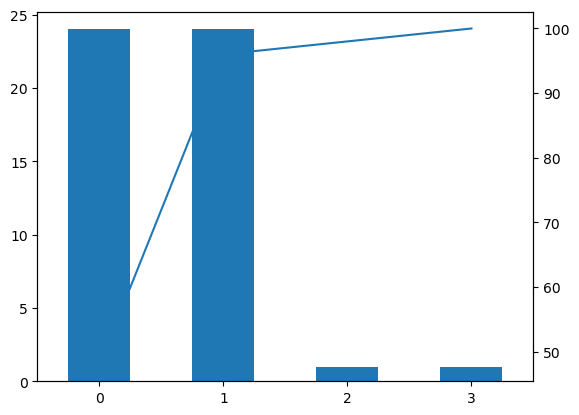

In [24]:
import matplotlib.pyplot as plt

width = .5 # width of a bar

df_strategyqa_train_performance['final-answer'].plot(kind='bar', width = width)
df_strategyqa_train_performance['accuracy'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(df_strategyqa_train_performance['num-iteration-to-correct'])-width])
ax.set_xticklabels(df_strategyqa_train_performance['num-iteration-to-correct'])

plt.show()

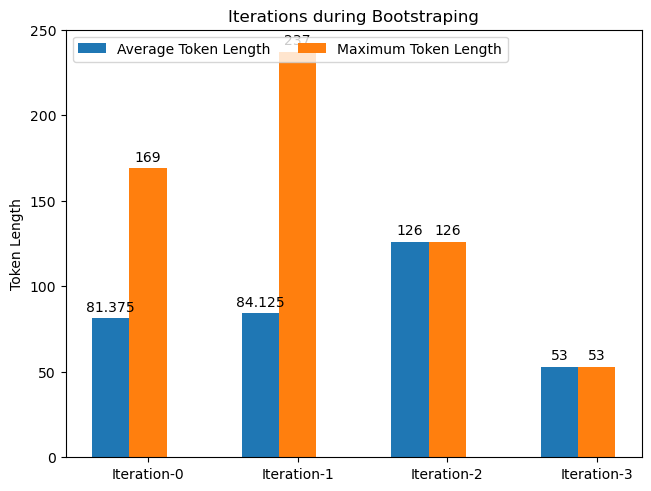

In [25]:
import matplotlib.pyplot as plt

iterations = [f"Iteration-{i}" for i in df_strategyqa_train_performance["num-iteration-to-correct"].to_list()]
token_length_stats = {
    'Average Token Length': df_strategyqa_train_performance["answer-tokens-average-length"].to_list(),
    'Maximum Token Length': df_strategyqa_train_performance["answer-tokens-max-length"].to_list(),
}

x = np.arange(len(iterations))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in token_length_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Token Length')
ax.set_title('Iterations during Bootstraping')
ax.set_xticks(x + width, iterations)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

The observed phenomenon can be attributed to the increasing difficulty level of corrected exemplars as the iteration progresses. Specifically, questions requiring multiple corrections exhibit a higher difficulty level than those resolvable in the initial iteration. (*Jiashuo Sun, Yi Luo, Yeyun Gong, Chen Lin, Yelong Shen, Jian Guo and Nan Duan. 2023. Enhancing Chain-of-Thoughts Prompting with Iterative Bootstrapping in Large Language Models. ArXiv, abs/2304.11657*)

In [ ]:
# Trials for a specific dataset and model 
# trial 1 = 8 samples = sampling from iteration 0 = easy exemplars = sampling-iteration-0
# trial 2 = 8 samples = sampling from iteration 1 = little hard exemplars = sampling-iteration-1
# trial 3 = 8 samples = sampling from iteration 2 = hard exemplars = sampling-iteration-2
# trial 4 = 8 samples = sampling from iteration 3 = harder exemplars = sampling-iteration-3
# trial 5 = 8 samples = sampling from iteration 4 = hardest exemplars = sampling-iteration-4
# trial 6 = 8 samples = sampling from iteration 0 to 4 = minimum 1 random sample from each iteration

# overall accuracy is the average accuracy of all trials

In [ ]:
# temprary because of batches and code completion
index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

In [7]:
# temprary because of batches and code completion
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")

df_strategyqa_train_1 = df_strategyqa_train[:last_idx]
df_strategyqa_train_iter_0 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 0]
df_strategyqa_train_iter_1 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 1]
df_strategyqa_train_iter_2 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 2]
df_strategyqa_train_iter_3 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 3]
df_strategyqa_train_iter_4 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 4]
df_strategyqa_train_iter_5 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 5]
df_strategyqa_train_iter_6 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 6]

In [8]:
last_idx

50

In [27]:
df_strategyqa_train_iter_0.shape

(24, 13)

In [9]:
num_samples = 8
trial_no = 0
strategyqa_demonstration_trials = []

In [10]:
if df_strategyqa_train_iter_0.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-0",
        "samples": df_strategyqa_train_iter_0.sample(n=8, random_state=1, axis=0)
    })

In [11]:
if df_strategyqa_train_iter_1.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-1",
        "samples": df_strategyqa_train_iter_1.sample(n=8, random_state=1, axis=0)
    })

In [13]:
if df_strategyqa_train_iter_2.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-2",
        "samples": df_strategyqa_train_iter_2.sample(n=8, random_state=1, axis=0)
    })

In [14]:
if df_strategyqa_train_iter_3.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-3",
        "samples": df_strategyqa_train_iter_3.sample(n=8, random_state=1, axis=0)
    })

In [15]:
if df_strategyqa_train_iter_4.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-4",
        "samples": df_strategyqa_train_iter_4.sample(n=8, random_state=1, axis=0)
    })

In [16]:
if df_strategyqa_train_iter_5.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-5",
        "samples": df_strategyqa_train_iter_5.sample(n=8, random_state=1, axis=0)
    })

In [17]:
if df_strategyqa_train_iter_6.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-6",
        "samples": df_strategyqa_train_iter_6.sample(n=8, random_state=1, axis=0)
    })

In [18]:
trial_no = trial_no + 1
samples_for_trial = pd.DataFrame(data=[], columns=df_strategyqa_train.columns.values)
sample_count = 0
while sample_count != num_samples:
    if df_strategyqa_train_iter_0.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_0.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_1.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_1.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_2.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_2.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_3.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_3.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_4.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_4.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_5.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_5.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_6.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_6.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
strategyqa_demonstration_trials.append({
    "trial-no": trial_no,
    "demonstration-pool": "sampling-iteration-mixed",
    "samples": samples_for_trial
})

/tmp/ipykernel_28/326827102.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_1.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/326827102.py:16: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_2.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/326827102.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_3.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/3268271

In [19]:
strategyqa_demonstration_trials

[{'trial-no': 1,
  'demonstration-pool': 'sampling-iteration-0',
  'samples':     Unnamed: 0                   qid                              term  \
  24          24  e56fdbdf08cdc8694536               The Powerpuff Girls   
  36          36  9a87e2e0f53e5d8689f2                            Sulfur   
  9            9  decb9886ca17f7af209d  Saint Vincent and the Grenadines   
  26          26  a96d28e1221bfbcf50a9                           CT scan   
  38          38  d24514ae216c7a55f4f0                             Miami   
  32          32  50c3af76816a5c2f07d2                               Ice   
  21          21  903178c36c89e5f55a20                    Model (person)   
  13          13  98a30c58fdff7676076c                      Biochemistry   
  
                                            description  \
  24                American animated television series   
  36             Chemical element with atomic number 16   
  9                            Country in the Caribbean   
 

In [ ]:
# below code for evaluation

In [40]:
df_strategyqa_eval = pd.read_json("/kaggle/input/strategyqa-dataset-for-thesis/strategyqa_train_filtered.json")
df_strategyqa_eval

qid          term                                        description  \
0      872      Swastika  a geometrical figure and an ancient religious ...   
1      874          Year         Orbital period of the Earth around the Sun   
2      875    Shropshire                                  County of England   
3      876    Shropshire                                  County of England   
4      877    Shropshire                                  County of England   
...    ...           ...                                                ...   
2816  9173        Cactus  Family of mostly succulent plants, adapted to ...   
2817  9180  Persian Gulf         An arm of the Indian Ocean in western Asia   
2818  9182     Drain fly                                  family of insects   
2819  9183        Lentil                                   Species of plant   
2820  9184        Lentil                                   Species of plant   

                                               question  answer  
0     Did the Hopi Indians use a symbol that was sim...    True  
1     is there a david bowie song with the word year...    True  
2     Were Charles Darwin and A.E. Housman born in S...    True  
3       Are there several  towns located in Shropshire?    True  
4     Is Lord Hill's column in Shropshire the talles...    True  
...                                                 ...     ...  
2816  Would an aerodynamic cactus dessicate more qui...    True  
2817  Would an oil miner be interested in the Persia...    True  
2818            Are drain flies able to survive bleach?    True  
2819                Are Lentil able to withstand frost?    True  
2820         Are Lentil able to withstand a wind storm?    True  

[2821 rows x 5 columns]

In [75]:
from ydata_profiling import ProfileReport

data_profile_config_path = "/kaggle/input/data-profile/bht_thesis_config_1.yaml"
strategyqa_data_profile_path = "/kaggle/working/df_strategyqa_train_filtered_report_v1.html"
profile = ProfileReport(df_strategyqa_eval, title="StrategyQA Evaluation Data Profiling Report v1", config_file=data_profile_config_path)
profile.to_file(strategyqa_data_profile_path)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"

In [41]:
file_exist = is_file_exist(file_name)
file_exist

True

In [42]:
if file_exist == True:
    df_strategyqa_eval = pd.read_csv(f"/kaggle/working/{file_name}")
else:
    default_ans = (['na' for i in range(df_strategyqa_eval.shape[0])], [False for i in range(df_strategyqa_eval.shape[0])])
    for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0-correct", default_ans[1])
df_strategyqa_eval

qid          term                                        description  \
0      872      Swastika  a geometrical figure and an ancient religious ...   
1      874          Year         Orbital period of the Earth around the Sun   
2      875    Shropshire                                  County of England   
3      876    Shropshire                                  County of England   
4      877    Shropshire                                  County of England   
...    ...           ...                                                ...   
2816  9173        Cactus  Family of mostly succulent plants, adapted to ...   
2817  9180  Persian Gulf         An arm of the Indian Ocean in western Asia   
2818  9182     Drain fly                                  family of insects   
2819  9183        Lentil                                   Species of plant   
2820  9184        Lentil                                   Species of plant   

                                               question  answer  \
0     Did the Hopi Indians use a symbol that was sim...    True   
1     is there a david bowie song with the word year...    True   
2     Were Charles Darwin and A.E. Housman born in S...    True   
3       Are there several  towns located in Shropshire?    True   
4     Is Lord Hill's column in Shropshire the talles...    True   
...                                                 ...     ...   
2816  Would an aerodynamic cactus dessicate more qui...    True   
2817  Would an oil miner be interested in the Persia...    True   
2818            Are drain flies able to survive bleach?    True   
2819                Are Lentil able to withstand frost?    True   
2820         Are Lentil able to withstand a wind storm?    True   

     trial-1-iter-cot-answer-8  trial-1-iter-cot-answer-8-correct  \
0                           na                              False   
1                           na                              False   
2                           na                              False   
3                           na                              False   
4                           na                              False   
...                        ...                                ...   
2816                        na                              False   
2817                        na                              False   
2818                        na                              False   
2819                        na                              False   
2820                        na                              False   

     trial-1-iter-cot-answer-7  trial-1-iter-cot-answer-7-correct  \
0                           na                              False   
1                           na                              False   
2                           na                              False   
3                           na                              False   
4                           na                              False   
...                        ...                                ...   
2816                        na                              False   
2817                        na                              False   
2818                        na                              False   
2819                        na                              False   
2820                        na                              False   

     trial-1-iter-cot-answer-6  ...  trial-3-iter-cot-answer-4  \
0                           na  ...                         na   
1                           na  ...                         na   
2                           na  ...                         na   
3                           na  ...                         na   
4                           na  ...                         na   
...                        ...  ...                        ...   
2816                        na  ...                         na   
2817                        na  ...                         na   
2

In [ ]:
index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

In [43]:
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
last_idx

0

In [54]:
batch_size = 50
df_strategyqa_eval_batches = make_batches_from_dataset(df_strategyqa_eval[last_idx:], batch_size)

In [44]:
iter_cot_few_shots_prompt = f"""Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. \
Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>"""

In [45]:
few_shots_exemplars = [
    f"""Q: {sfd[1]["term"]}, {sfd[1]["description"]}, {sfd[1]["question"]}
{sfd[1]["iter-cot-answer"]}""" for sfd in strategyqa_demonstration_trials[0]["samples"].iterrows()
]

In [46]:
few_shots_exemplars

['Q: The Powerpuff Girls, American animated television series, Could the Powerpuff Girls hypothetically attend the Camden Military Academy?\nA: Reasoning: \nThe Powerpuff girls are fictional characters in an animated TV show. They do not exist in real life. Therefore they cannot attend any school, including the Camden Military Academy. \nFinal Answer: No',
 'Q: Sulfur, Chemical element with atomic number 16, Would food made with black salt smell of sulfur?\nA: Reasoning: Black Salt contains Sodium Chloride (NaCl) and Magnesium Sulfate (MgSO4). When heated, it releases Hydrogen Sulfide gas (H2S), which has an unpleasant odor similar to rotten eggs. Therefore, food made with black salt may smell like sulfur. Final Answer: Yes',
 'Q: Saint Vincent and the Grenadines, Country in the Caribbean, Is the language used in Saint Vincent and the Grenadines rooted in English?\nA: Reasoning: The official language of St. Vincent and the Grenadines is English. It has been influenced by African langua

In [47]:
few_shots_exemplars[0]

'Q: The Powerpuff Girls, American animated television series, Could the Powerpuff Girls hypothetically attend the Camden Military Academy?\nA: Reasoning: \nThe Powerpuff girls are fictional characters in an animated TV show. They do not exist in real life. Therefore they cannot attend any school, including the Camden Military Academy. \nFinal Answer: No'

In [48]:
print(iter_cot_few_shots_prompt + "\n\n" + "\n\n".join(few_shots_exemplars[:6]))

Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: The Powerpuff Girls, American animated television series, Could the Powerpuff Girls hypothetically attend the Camden Military Academy?
A: Reasoning: 
The Powerpuff girls are fictional characters in an animated TV show. They do not exist in real life. Therefore they cannot attend any school, including the Camden Military Academy. 


In [ ]:
file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

In [55]:
batch_count = 1
got_exception = False
for df_strategyqa_eval_batch in df_strategyqa_eval_batches:
    print(f"Batch: {batch_count}")
    print("-----------------------------")
    got_exception = False
    for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
        print(f"Trial: {strategyqa_demonstration_trial['trial-no']}")
        print("-----------------------------")
        few_shots_exemplars = [
            f"""Q: {sfd[1]["term"]}, {sfd[1]["description"]}, {sfd[1]["question"]}
    {sfd[1]["iter-cot-answer"]}""" for sfd in strategyqa_demonstration_trial["samples"].iterrows()
        ]
        got_exception = False
        for strategyqa in df_strategyqa_eval_batch.iterrows():
            question = f"""{strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}"""
            try:
                iter_cot_inference_module(strategyqa_demonstration_trial["trial-no"], batch_count, few_shots_exemplars, strategyqa[0], question, strategyqa[1]["answer"])
            except Exception as exp:
                # print message
                print(f"Batch: {batch_count}, Trial: {strategyqa_demonstration_trial['trial-no']}")
                print(exp)
                # save data till previous iteration df, file_name, idx_file_name
                if last_idx != 0:
                    save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
                got_exception = True
                break
        if got_exception == True:
            break
        time.sleep(60)
    if got_exception == True:
        break
    last_idx = last_idx + batch_size
    save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
    batch_count = batch_count + 1
    time.sleep(60)

Batch: 1
-----------------------------
Trial: 1
-----------------------------
Generating...


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration

trail no : 1, batch number : 1, index : 0
------------------------------------------
<unk>Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Swastika, a geometrical figure and an ancient religious icon in the cultures of Eurasia and 20th-century symbol of Nazism, Did the Hopi Indians use a symbol that was similar to the swastika?
A: Reasoning: The Hopi Indians were known to have u

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration

trail no : 1, batch number : 1, index : 0
------------------------------------------
<unk>Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: The Powerpuff Girls, American animated television series, Could the Powerpuff Girls hypothetically attend the Camden Military Academy?
    A: Reasoning: 
The Powerpuff girls are fictional characters in an animated TV show. They do not exist i

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


trail no : 2, batch number : 1, index : 1
------------------------------------------
<unk>Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Biochemistry, study of chemical processes in living organisms, Would a geographer use biochemistry in their work?
    A: Reasoning: Yes, because biochemistry can help them understand how different environments affect the growth and developmen

KeyboardInterrupt: 

In [56]:
df_strategyqa_eval

qid          term                                        description  \
0      872      Swastika  a geometrical figure and an ancient religious ...   
1      874          Year         Orbital period of the Earth around the Sun   
2      875    Shropshire                                  County of England   
3      876    Shropshire                                  County of England   
4      877    Shropshire                                  County of England   
...    ...           ...                                                ...   
2816  9173        Cactus  Family of mostly succulent plants, adapted to ...   
2817  9180  Persian Gulf         An arm of the Indian Ocean in western Asia   
2818  9182     Drain fly                                  family of insects   
2819  9183        Lentil                                   Species of plant   
2820  9184        Lentil                                   Species of plant   

                                               question  answer  \
0     Did the Hopi Indians use a symbol that was sim...    True   
1     is there a david bowie song with the word year...    True   
2     Were Charles Darwin and A.E. Housman born in S...    True   
3       Are there several  towns located in Shropshire?    True   
4     Is Lord Hill's column in Shropshire the talles...    True   
...                                                 ...     ...   
2816  Would an aerodynamic cactus dessicate more qui...    True   
2817  Would an oil miner be interested in the Persia...    True   
2818            Are drain flies able to survive bleach?    True   
2819                Are Lentil able to withstand frost?    True   
2820         Are Lentil able to withstand a wind storm?    True   

                              trial-1-iter-cot-answer-8  \
0     A: Reasoning: The Hopi Indians did not use a s...   
1     A: Reasoning: David Bowie had several songs wi...   
2     A: Reasoning: Charles Darwin was born in Shrew...   
3     A: Reasoning: There are multiple towns located...   
4     A: Reasoning: Lord Hill's Column stands at 30 ...   
...                                                 ...   
2816                                                 na   
2817                                                 na   
2818                                                 na   
2819                                                 na   
2820                                                 na   

      trial-1-iter-cot-answer-8-correct  \
0                                 False   
1                                 False   
2                                 False   
3                                  True   
4                                  True   
...                                 ...   
2816                              False   
2817                              False   
2818                              False   
2819                              False   
2820                              False   

                              trial-1-iter-cot-answer-7  \
0     A: Reasoning: \nYes, the Hopis did use a symbo...   
1     A: Reasoning: David Bowie had several songs wi...   
2     A: Reasoning: Charles Darwin was born in Shrew...   
3     A: Reasoning: There are numerous small village...   
4     A: Reasoning: Lord Hill's Column stands at 30 ...   
...                                                 ...   
2816                                                 na   
2817                                                 na   
2818                                                 na   
2819                                                 na   
2820                                                 na   

      trial-1-iter-cot-answer-7-correct  \
0                                  True   
1                                 False   
2                                  True   
3                                  True   
4                                  True   
...                                 ...   
2816             

In [57]:
last_idx

50

In [ ]:
file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

In [58]:
save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")

In [27]:
strategyqa_demonstration_trial

{'trial-no': 3,
 'demonstration-pool': 'sampling-iteration-mixed',
 'samples':    Unnamed: 0                   qid                 term  \
 24         24  e56fdbdf08cdc8694536  The Powerpuff Girls   
 33         33  3a7d825a0fcb4211742f         Biochemistry   
 2           2  41450dbd623437269f8f    Depression (mood)   
 1           1  4668264df84fb7c25b39           The Police   
 24         24  e56fdbdf08cdc8694536  The Powerpuff Girls   
 33         33  3a7d825a0fcb4211742f         Biochemistry   
 2           2  41450dbd623437269f8f    Depression (mood)   
 1           1  4668264df84fb7c25b39           The Police   
 
                                         description  \
 24              American animated television series   
 33  study of chemical processes in living organisms   
 2                     state of low mood and fatigue   
 1                                 English rock band   
 24              American animated television series   
 33  study of chemical processes in

In [ ]:
file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

In [23]:
df_strategyqa_eval = pd.read_csv(f"/kaggle/working/{file_name}")

# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
#num_record = df_strategyqa_eval.shape[0]
num_record = last_idx
print(num_record)

# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
df_strategyqa_eval = df_strategyqa_eval[:num_record]


dataset_name = []
model_name = []
trial_no = []
demonstration_pool = []
iter_cot_answer_8_accuracy = []
iter_cot_answer_7_accuracy = []
iter_cot_answer_6_accuracy = []
iter_cot_answer_5_accuracy = []
iter_cot_answer_4_accuracy = []
iter_cot_answer_3_accuracy = []
iter_cot_answer_2_accuracy = []
iter_cot_answer_1_accuracy = []
iter_cot_answer_0_accuracy = []
iter_cot_answer_avg_accuracy = []

for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
    dataset_name.append("StrategyQA")
    model_name.append(llm_name)
    trial_no.append(strategyqa_demonstration_trial["trial-no"])
    demonstration_pool.append(strategyqa_demonstration_trial["demonstration-pool"])
    
    answer_8_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8-correct"]].shape[0]) / float(num_record) * 100.00
    answer_7_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7-correct"]].shape[0]) / float(num_record) * 100.00
    answer_6_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6-correct"]].shape[0]) / float(num_record) * 100.00
    answer_5_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5-correct"]].shape[0]) / float(num_record) * 100.00
    answer_4_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4-correct"]].shape[0]) / float(num_record) * 100.00
    answer_3_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3-correct"]].shape[0]) / float(num_record) * 100.00
    answer_2_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2-correct"]].shape[0]) / float(num_record) * 100.00
    answer_1_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1-correct"]].shape[0]) / float(num_record) * 100.00
    answer_0_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0-correct"]].shape[0]) / float(num_record) * 100.00
    answer_avg_accuracy = (answer_0_accuracy + answer_1_accuracy + answer_2_accuracy + answer_3_accuracy + answer_4_accuracy + answer_5_accuracy + answer_6_accuracy + answer_7_accuracy + answer_8_accuracy) / 9.00
    
    iter_cot_answer_8_accuracy.append(answer_8_accuracy)
    iter_cot_answer_7_accuracy.append(answer_7_accuracy)
    iter_cot_answer_6_accuracy.append(answer_6_accuracy)
    iter_cot_answer_5_accuracy.append(answer_5_accuracy)
    iter_cot_answer_4_accuracy.append(answer_4_accuracy)
    iter_cot_answer_3_accuracy.append(answer_3_accuracy)
    iter_cot_answer_2_accuracy.append(answer_2_accuracy)
    iter_cot_answer_1_accuracy.append(answer_1_accuracy)
    iter_cot_answer_0_accuracy.append(answer_0_accuracy)
    iter_cot_answer_avg_accuracy.append(answer_avg_accuracy)


dict_strategyqa_eval = {
    "dataset-name": dataset_name,
    "model-name": model_name,
    "trial-no": trial_no,
    "demonstration-pool": demonstration_pool,
    "iter-cot-answer-8-accuracy": iter_cot_answer_8_accuracy,
    "iter-cot-answer-7-accuracy": iter_cot_answer_7_accuracy,
    "iter-cot-answer-6-accuracy": iter_cot_answer_6_accuracy,
    "iter-cot-answer-5-accuracy": iter_cot_answer_5_accuracy,
    "iter-cot-answer-4-accuracy": iter_cot_answer_4_accuracy,
    "iter-cot-answer-3-accuracy": iter_cot_answer_3_accuracy,
    "iter-cot-answer-2-accuracy": iter_cot_answer_2_accuracy,
    "iter-cot-answer-1-accuracy": iter_cot_answer_1_accuracy,
    "iter-cot-answer-0-accuracy": iter_cot_answer_0_accuracy,
    "iter-cot-answer-avg-accuracy": iter_cot_answer_avg_accuracy
}

dict_strategyqa_eval

50


{'dataset-name': ['StrategyQA', 'StrategyQA', 'StrategyQA'],
 'model-name': ['alpaca-lora-13b', 'alpaca-lora-13b', 'alpaca-lora-13b'],
 'trial-no': [1, 2, 3],
 'demonstration-pool': ['sampling-iteration-0',
  'sampling-iteration-1',
  'sampling-iteration-mixed'],
 'iter-cot-answer-8-accuracy': [78.0, 70.0, 74.0],
 'iter-cot-answer-7-accuracy': [84.0, 74.0, 60.0],
 'iter-cot-answer-6-accuracy': [82.0, 76.0, 56.00000000000001],
 'iter-cot-answer-5-accuracy': [76.0, 62.0, 68.0],
 'iter-cot-answer-4-accuracy': [84.0, 68.0, 72.0],
 'iter-cot-answer-3-accuracy': [80.0, 62.0, 76.0],
 'iter-cot-answer-2-accuracy': [88.0, 80.0, 78.0],
 'iter-cot-answer-1-accuracy': [72.0, 76.0, 72.0],
 'iter-cot-answer-0-accuracy': [54.0, 54.0, 54.0],
 'iter-cot-answer-avg-accuracy': [77.55555555555556,
  69.11111111111111,
  67.77777777777777]}

In [21]:
file_exist = is_file_exist("iter-cot-inference-performance.csv")
file_exist

True

In [24]:
if file_exist == True:
    df_iter_cot_inference_performance = pd.read_csv("/kaggle/working/iter-cot-inference-performance.csv")
    for i in range(len(strategyqa_demonstration_trials)):
        df_performance_found = df_iter_cot_inference_performance[(df_iter_cot_inference_performance["dataset-name"] == dict_strategyqa_eval["dataset-name"][i]) & 
                        (df_iter_cot_inference_performance["model-name"] == dict_strategyqa_eval["model-name"][i]) &
                        (df_iter_cot_inference_performance["trial-no"] == dict_strategyqa_eval["trial-no"][i])]
        idx = df_iter_cot_inference_performance.shape[0]
        if df_performance_found.shape[0] == 1:
            idx = df_performance_found.index.values[0]
        df_iter_cot_inference_performance.loc[idx, "dataset-name"] = dict_strategyqa_eval["dataset-name"][i]
        df_iter_cot_inference_performance.loc[idx, "model-name"] = dict_strategyqa_eval["model-name"][i]
        df_iter_cot_inference_performance.loc[idx, "trial-no"] = dict_strategyqa_eval["trial-no"][i]
        df_iter_cot_inference_performance.loc[idx, "demonstration-pool"] = dict_strategyqa_eval["demonstration-pool"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-8-accuracy"] = dict_strategyqa_eval["iter-cot-answer-8-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-7-accuracy"] = dict_strategyqa_eval["iter-cot-answer-7-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-6-accuracy"] = dict_strategyqa_eval["iter-cot-answer-6-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-5-accuracy"] = dict_strategyqa_eval["iter-cot-answer-5-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-4-accuracy"] = dict_strategyqa_eval["iter-cot-answer-4-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-3-accuracy"] = dict_strategyqa_eval["iter-cot-answer-3-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-2-accuracy"] = dict_strategyqa_eval["iter-cot-answer-2-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-1-accuracy"] = dict_strategyqa_eval["iter-cot-answer-1-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-0-accuracy"] = dict_strategyqa_eval["iter-cot-answer-0-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-avg-accuracy"] = dict_strategyqa_eval["iter-cot-answer-avg-accuracy"][i]
else:
    df_iter_cot_inference_performance = pd.DataFrame(data=dict_strategyqa_eval)

df_iter_cot_inference_performance.to_csv("/kaggle/working/iter-cot-inference-performance.csv", index=False)

In [25]:
df_iter_cot_inference_performance

dataset-name       model-name  trial-no        demonstration-pool  \
0   StrategyQA  alpaca-lora-13b         1      sampling-iteration-0   
1   StrategyQA  alpaca-lora-13b         2      sampling-iteration-1   
2   StrategyQA  alpaca-lora-13b         3  sampling-iteration-mixed   

   iter-cot-answer-8-accuracy  iter-cot-answer-7-accuracy  \
0                        78.0                        84.0   
1                        70.0                        74.0   
2                        74.0                        60.0   

   iter-cot-answer-6-accuracy  iter-cot-answer-5-accuracy  \
0                        82.0                        76.0   
1                        76.0                        62.0   
2                        56.0                        68.0   

   iter-cot-answer-4-accuracy  iter-cot-answer-3-accuracy  \
0                        84.0                        80.0   
1                        68.0                        62.0   
2                        72.0                        76.0   

   iter-cot-answer-2-accuracy  iter-cot-answer-1-accuracy  \
0                        88.0                        72.0   
1                        80.0                        76.0   
2                        78.0                        72.0   

   iter-cot-answer-0-accuracy  iter-cot-answer-avg-accuracy  
0                        54.0                     77.555556  
1                        54.0                     69.111111  
2                        54.0                     67.777778

In [26]:
df_iter_cot_inference_performance.dtypes

dataset-name                     object
model-name                       object
trial-no                          int64
demonstration-pool               object
iter-cot-answer-8-accuracy      float64
iter-cot-answer-7-accuracy      float64
iter-cot-answer-6-accuracy      float64
iter-cot-answer-5-accuracy      float64
iter-cot-answer-4-accuracy      float64
iter-cot-answer-3-accuracy      float64
iter-cot-answer-2-accuracy      float64
iter-cot-answer-1-accuracy      float64
iter-cot-answer-0-accuracy      float64
iter-cot-answer-avg-accuracy    float64
dtype: object

In [27]:
accuracy_stats = {
    inference_performance[1]["trial-no"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_iter_cot_inference_performance.iterrows()}

accuracy_stats

{1: [54.0, 72.0, 88.0, 80.0, 84.0, 76.0, 82.0, 84.0, 78.0],
 2: [54.0, 76.0, 80.0, 62.0, 68.0, 62.0, 76.0, 74.0, 70.0],
 3: [54.0, 72.0, 78.0, 76.0, 72.0, 68.0, 56.00000000000001, 60.0, 74.0]}

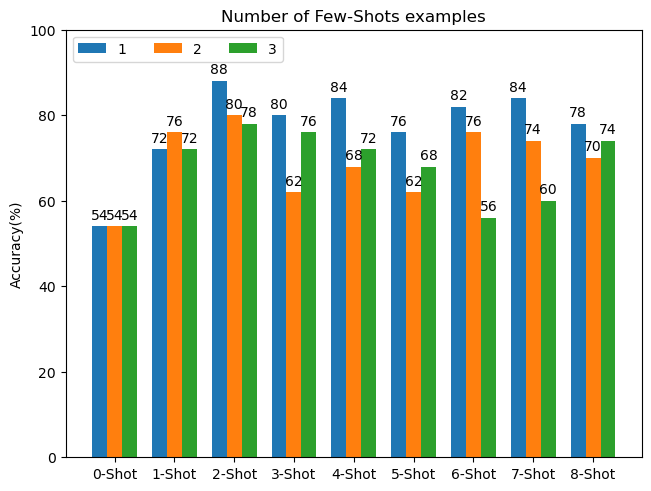

In [28]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

few_shots_examples = [f"{i}-Shot" for i in range(9)]
accuracy_stats = {
    inference_performance[1]["trial-no"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_iter_cot_inference_performance.iterrows()}

x = np.arange(len(few_shots_examples))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy(%)')
ax.set_title('Number of Few-Shots examples')
ax.set_xticks(x + width, few_shots_examples)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

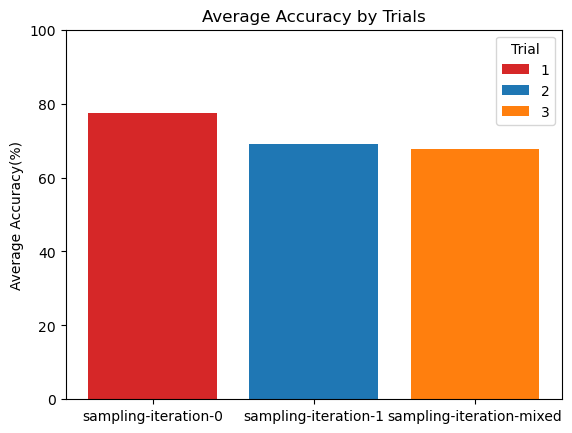

In [26]:
# average accuracy chart for each trial
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

demostration_pool = df_iter_cot_inference_performance["demonstration-pool"]
average_accuracy = df_iter_cot_inference_performance["iter-cot-answer-avg-accuracy"]
bar_labels = df_iter_cot_inference_performance["trial-no"]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(demostration_pool, average_accuracy, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Accuracy(%)')
ax.set_title('Average Accuracy by Trials')
ax.legend(title='Trial')
ax.set_ylim(0, 100)

plt.show()

In [38]:
df_iter_cot_inference_performance_v2 = df_iter_cot_inference_performance[["dataset-name", "model-name", "iter-cot-answer-avg-accuracy"]].groupby(by=["dataset-name", "model-name"]).mean()
df_iter_cot_inference_performance_v2

iter-cot-answer-avg-accuracy
dataset-name model-name                                   
StrategyQA   alpaca-lora-13b                     71.481481

In [40]:
df_iter_cot_inference_performance_v2 = df_iter_cot_inference_performance_v2.reset_index()
df_iter_cot_inference_performance_v2

dataset-name       model-name  iter-cot-answer-avg-accuracy
0   StrategyQA  alpaca-lora-13b                     71.481481

In [49]:
file_exist = is_file_exist("iter-cot-inference-performance-v2.csv")
file_exist

True

In [50]:
if file_exist == True:
    df_itercot_inference_perfo_v2 = pd.read_csv("/kaggle/working/iter-cot-inference-performance-v2.csv")
    
    df_performance_found = df_iter_cot_inference_performance[(df_iter_cot_inference_performance["dataset-name"] == dict_strategyqa_eval["dataset-name"][i]) & 
                        (df_iter_cot_inference_performance["model-name"] == dict_strategyqa_eval["model-name"][i]) &
                        (df_iter_cot_inference_performance["trial-no"] == dict_strategyqa_eval["trial-no"][i])]
    
    df_performance_found = df_itercot_inference_perfo_v2[(df_itercot_inference_perfo_v2["dataset-name"] == df_iter_cot_inference_performance_v2.loc[0, "dataset-name"]) & 
                        (df_itercot_inference_perfo_v2["model-name"] == df_iter_cot_inference_performance_v2.loc[0, "model-name"])]
    idx = df_itercot_inference_perfo_v2.shape[0]
    if df_performance_found.shape[0] == 1:
        idx = df_performance_found.index.values[0]
    df_itercot_inference_perfo_v2.loc[idx, "dataset-name"] = df_iter_cot_inference_performance_v2.loc[0, "dataset-name"]
    df_itercot_inference_perfo_v2.loc[idx, "model-name"] = df_iter_cot_inference_performance_v2.loc[0, "model-name"]
    df_itercot_inference_perfo_v2.loc[idx, "iter-cot-answer-avg-accuracy"] = df_iter_cot_inference_performance_v2.loc[0, "iter-cot-answer-avg-accuracy"]
    df_iter_cot_inference_performance_v2 = df_itercot_inference_perfo_v2
    
df_iter_cot_inference_performance_v2.to_csv("/kaggle/working/iter-cot-inference-performance-v2.csv", index=False)

In [51]:
df_iter_cot_inference_performance_v2

dataset-name       model-name  iter-cot-answer-avg-accuracy
0   StrategyQA  alpaca-lora-13b                     71.481481

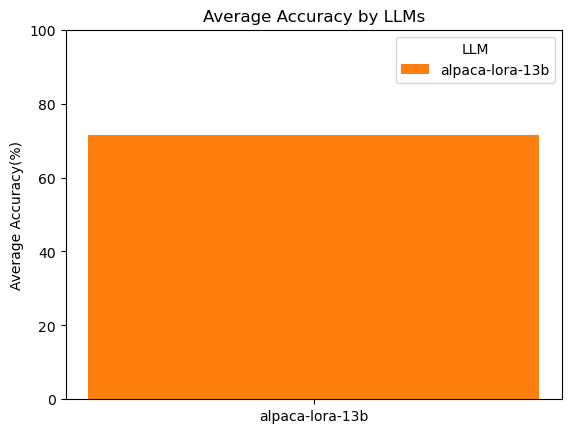

In [52]:
# average accuracy chart for each dataset and llm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

model_name = df_iter_cot_inference_performance_v2["model-name"]
average_accuracy = df_iter_cot_inference_performance_v2["iter-cot-answer-avg-accuracy"]
bar_labels = model_name
#bar_colors = ['tab:red', 'tab:blue', 'tab:orange']
bar_colors = ['tab:orange']

ax.bar(model_name, average_accuracy, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Accuracy(%)')
ax.set_title('Average Accuracy by LLMs')
ax.legend(title='LLM')
ax.set_ylim(0, 100)

plt.show()

In [ ]:
#table 1, section 4.3, section 4.4, section 4.5.1, figure 2, figure 4, table 2, figure 5, figure 6, table 5, figure 8, 

In [ ]:
#bootstraping part: figure 6, figure 4, figure 2
#inference part: figure 5, table 2, table 1, figure 10 from 2201.11903